# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import ast
import re

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./main_task.csv
./kaggle_task.csv
./requirements.txt
./submission.csv
./baseline-sf-tripadvisor-rating-v2-7-revyakin.ipynb
./sample_submission.csv
./.ipynb_checkpoints/baseline-sf-tripadvisor-rating-v2-7-revyakin-checkpoint.ipynb
./.ipynb_checkpoints/your_first_model-checkpoint.ipynb
./.ipynb_checkpoints/your_first_model_www.tripadvisor.ru-checkpoint.ipynb


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# фиксируем так же "текущую дату", чтобы ваши эксперименты с дельтой относительно
# текущего времени так же были воспроизводимы
CURRENT_DATE = pd.to_datetime('2020-12-08')

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Подробнее по признакам:
* ```Restaurant_id``` — идентификационный номер ресторана / сети ресторанов;
* ```City``` — город, в котором находится ресторан;
* ```Cuisine Style``` — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* ```Ranking``` — место, которое занимает данный ресторан среди всех ресторанов своего города;
* ```Rating``` — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* ```Price Range``` — диапазон цен в ресторане;
* ```Number of Reviews``` — количество отзывов о ресторане;
* ```Reviews``` — данные о двух отзывах, которые отображаются на сайте ресторана;
* ```URL_TA``` — URL страницы ресторана на TripAdvosor;
* ```ID_TA``` — идентификатор ресторана в базе данных TripAdvisor.

# DATA

In [4]:
DATA_DIR = '.'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# EDA 
Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

### Посмотрим распределение признака

<AxesSubplot:>

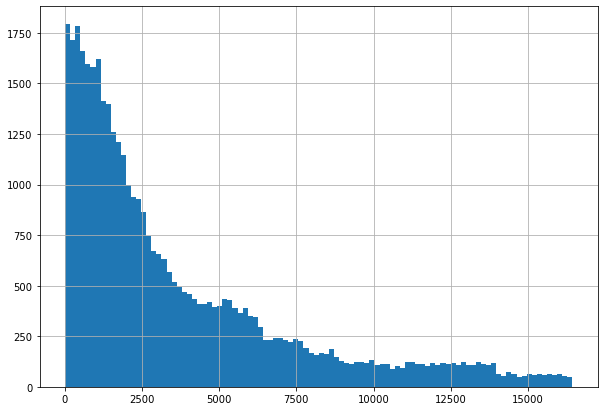

In [5]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

<AxesSubplot:>

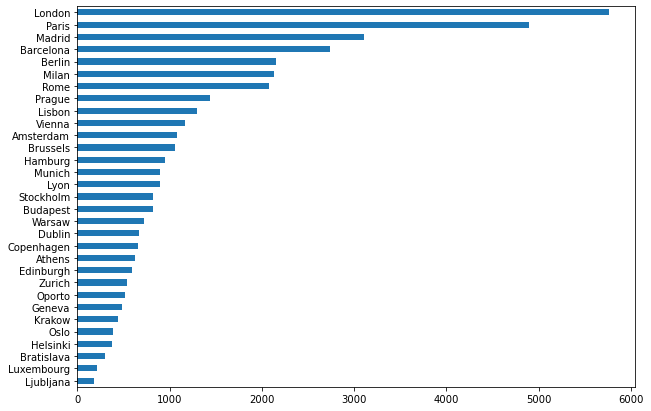

In [6]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

<AxesSubplot:>

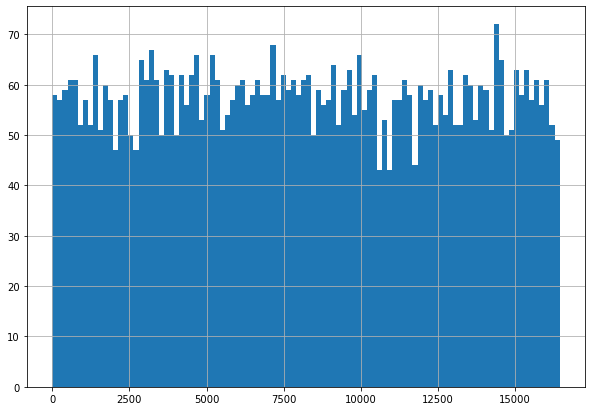

In [7]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

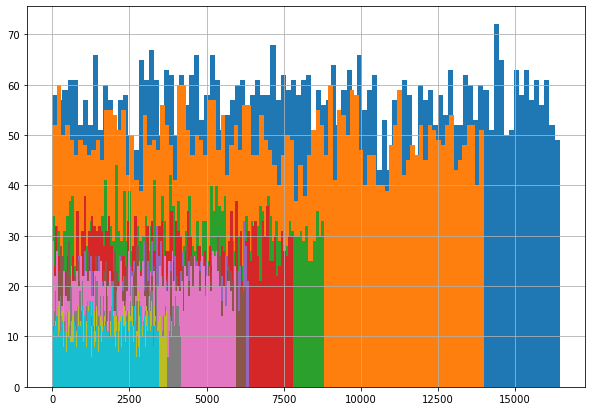

In [8]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Такое распределение явный признак того, что нужно учитывать Ranking и другие количественные показатели с учетом количества ресторанов в городе

### Посмотрим распределение целевой переменной

<AxesSubplot:>

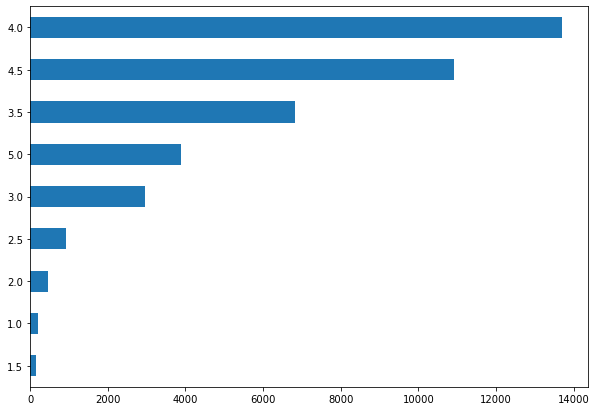

In [9]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

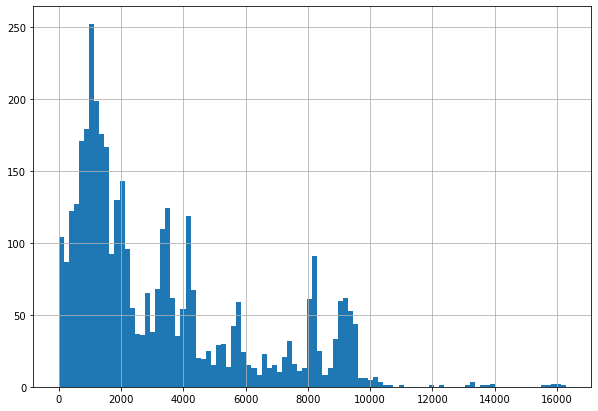

In [10]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

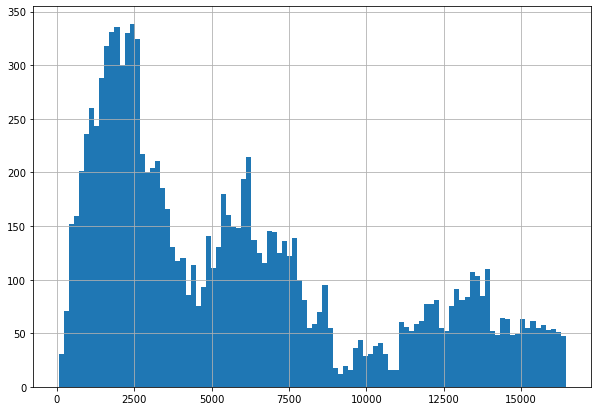

In [11]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

## Класс для обработки
Делает чистку данных и вводит новые признаки

In [12]:
class ProcData():
    def __init__(self, df_train, df_test):
        self.data = df_test.append(df_train, sort=False).reset_index(drop=True)


    def proc_number_reviews(self):
        # Введем новый признак наличия Number of Reviews
        self.data['Number_of_Reviews_isNAN'] = pd.isna(
            self.data['Number of Reviews']
        ).astype('uint8')

        # Заполняем пропуски Number of Reviews средним по городу
        self.data['Number of Reviews'] = self.data['Number of Reviews'].fillna(
            self.data.groupby('City')['Number of Reviews'].transform('mean')
        )

    def proc_reviews(self):
        # В данных Reviews есть несколько nan
        # Их нужно обернуть в кавычки, что бы сработал literal_eval
        nan_comp = re.compile('([^\'\w])(nan)([^\'\w])')
        def clean_reviews(reviews):
            if pd.isna(reviews):
                return np.NaN

            # исправляем nan без кавычек
            reviews = nan_comp.sub(r"\1'\2'\3", reviews)
            reviews = ast.literal_eval(reviews)  # теперь тут список

            if not reviews[0]:  # для пустого списка делаем просто NaN
                return np.NaN

            return reviews

        self.data['Reviews'] = self.data['Reviews'].apply(clean_reviews)

        # Создадим новые переменные на основе дат двух отзывов
        # Разница дней между двумя отзывами и разница дней между последним
        # отзывом и текущей датой
        self.data['data_delta_current'] = np.NaN
        self.data['data_delta_between'] = np.NaN

        def fill_deltas(row):
            if type(row['Reviews']) is not list:
                return row

            # исправляем ошибку, что нет отзывов после обработки Reviews в clean_reviews
            row['Number_of_Reviews_isNAN'] = 0

            dts = sorted([pd.to_datetime(d) for d in row['Reviews'][1]])
            if len(dts) == 2:
                row['data_delta_current'] = (CURRENT_DATE - dts[1]).days
                row['data_delta_between'] = (dts[1] - dts[0]).days
            else:
                row['data_delta_current'] = (CURRENT_DATE - dts[0]).days

            return row

        self.data = self.data.apply(fill_deltas, axis=1)

        # Заполним пустоты дельт по датам средними по городам
        self.data['data_delta_between'] = self.data['data_delta_between'].fillna(
            self.data.groupby('City')['data_delta_between'].transform('mean')
        )

        self.data['data_delta_current'] = self.data['data_delta_current'].fillna(
            self.data.groupby('City')['data_delta_current'].transform('mean')
        )

    def proc_city(self):
        # Просто делаем dummies из City
        self.data = pd.concat([
            self.data,
            pd.get_dummies(self.data['City'], dummy_na=True, prefix='City')
        ], axis=1)

    def proc_price(self):
        # Обработка 'Price Range'
        # Введем новый признк и заменим Price Range на числа (10, 50, 200)
        self.data['Price_Range_isNAN'] = pd.isna(
            self.data['Price Range']
        ).astype('uint8')

        self.data['Price Range'] = self.data['Price Range'].map({
            '$': 10,
            '$$ - $$$': 50,
            '$$$$': 200,
            np.NaN: 50,   # неизвестные примем, как из среднего диапазона
        })

    def proc_cuisins(self):
        # И опять введем признак по отсутствию этих данных
        self.data['Cuisine_Style_isNAN'] = pd.isna(
            self.data['Cuisine Style']
        ).astype('uint8')

        # Делаем python-списки из строк в 'Cuisine Style', если они не пустые
        self.data['Cuisine Style'] = self.data['Cuisine Style'].apply(
            lambda c: ast.literal_eval(c) if pd.notna(c) else np.NaN
        )

        # Сделаем предварительный словарь с данными кухонь по городам и средним количеством кухонь
        CS_City = {}
        CS_City_Mean = {}
        for city in self.data.City.unique():
            tmp = self.data[self.data.City == city]['Cuisine Style']
            CS_City[city] = tmp.explode().value_counts()
            CS_City_Mean[city] = round(tmp.dropna().apply(lambda x: len(x)).mean())
            
        # Заполним пустоты по 'Cuisine Style' списком из самых популярных кухонь в городе
        def fill_cuisine_style(row):
            if type(row['Cuisine Style']) is list:
                return row['Cuisine Style']

            return list(
                CS_City[row['City']]
                .index[:CS_City_Mean[row['City']]]
            )

        self.data['Cuisine Style'] = self.data.apply(fill_cuisine_style, axis=1)

        # Запишем новый признак: количество типов кухни
        self.data['Cuisine_Style_Count'] = self.data['Cuisine Style'].apply(lambda x: len(x))

        # Наиболее популярные кухни
        CS_top5 = set(self.data['Cuisine Style'].explode().value_counts()[:5].index)
        
        # Делаем dummies из популярных кухонь
        self.data = pd.concat([
            self.data,
            self.data['Cuisine Style'].apply(
                    lambda x: list(CS_top5 & set(x))
            ).str.join('|').str.get_dummies().add_prefix('CS_')
        ], axis=1)

    def make_w(self):
        # Найдем число ресторанов в кажом городе
        self.data['restaurants_in_city'] = self.data['City'].map(
            self.data['City'].value_counts().to_dict()
        )

        # На основе данных по числу ресторанов в городе и взвесим их относительно 
        # Ранка и Числа отзывов
        self.data['W_Ranking'] = self.data['Ranking'] / self.data['restaurants_in_city']
        self.data['W_Number_of_Reviews'] = self.data['Number of Reviews'] / self.data['restaurants_in_city']

    def drop(self):
        # Удаляем ненужные больше признаки
        self.data.drop(
            columns=['City', 'Restaurant_id', 'Cuisine Style', 'Ranking',
                     'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'],
        inplace=True)

    def Proc(self):
        # Выполнение всех обработок за раз
        self.proc_number_reviews()
        self.proc_reviews()
        self.proc_cuisins()
        self.proc_city()
        self.proc_price()
        self.make_w()
        self.drop()

    def get_data(self):
        return self.data

In [13]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

In [14]:
# Создаем экземпляр класса обработки
data = ProcData(df_train, df_test)

In [15]:
# Выполняем обработку
data.Proc()

In [16]:
data.get_data().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Price Range              50000 non-null  int64  
 1   sample                   50000 non-null  int64  
 2   Rating                   50000 non-null  float64
 3   Number_of_Reviews_isNAN  50000 non-null  int64  
 4   data_delta_current       50000 non-null  float64
 5   data_delta_between       50000 non-null  float64
 6   Cuisine_Style_isNAN      50000 non-null  uint8  
 7   Cuisine_Style_Count      50000 non-null  int64  
 8   CS_European              50000 non-null  int64  
 9   CS_Gluten Free Options   50000 non-null  int64  
 10  CS_Italian               50000 non-null  int64  
 11  CS_Mediterranean         50000 non-null  int64  
 12  CS_Vegetarian Friendly   50000 non-null  int64  
 13  City_Amsterdam           50000 non-null  uint8  
 14  City_Athens           

In [17]:
data.get_data().sample(5)

,Price Range,sample,Rating,Number_of_Reviews_isNAN,data_delta_current,data_delta_between,Cuisine_Style_isNAN,Cuisine_Style_Count,CS_European,CS_Gluten Free Options,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price_Range_isNAN,restaurants_in_city,W_Ranking,W_Number_of_Reviews
19958,50,1,4.0,1,1321.476782,144.694755,0,2,0,0,...,0,0,0,0,0,0,0,3395,1.696907,0.039966
33542,50,1,3.0,0,1321.476782,144.694755,0,1,0,0,...,0,0,0,0,0,0,1,3395,1.758174,0.004418
11871,50,1,3.0,0,1071.000000,240.000000,0,4,0,0,...,0,0,0,0,0,0,0,2694,1.838159,0.080549
44782,50,1,3.0,0,1170.000000,129.000000,0,2,0,0,...,0,0,0,0,0,0,0,6108,2.149804,0.042567
27270,10,1,3.5,0,1117.000000,19.000000,0,6,0,1,...,0,0,0,0,0,0,0,2694,1.927988,0.169265


### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

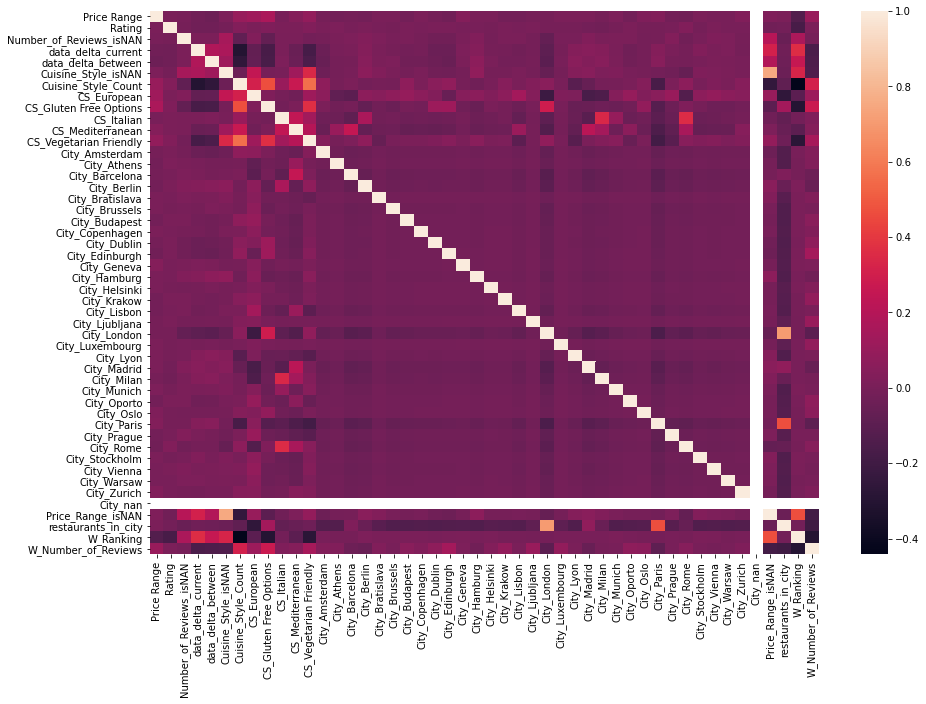

In [18]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.get_data().drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing

#### Запускаем и проверяем что получилось

In [19]:
#df_preproc = preproc_data(data)
df_preproc = data.get_data()
df_preproc.sample(10)

,Price Range,sample,Rating,Number_of_Reviews_isNAN,data_delta_current,data_delta_between,Cuisine_Style_isNAN,Cuisine_Style_Count,CS_European,CS_Gluten Free Options,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price_Range_isNAN,restaurants_in_city,W_Ranking,W_Number_of_Reviews
31070,50,1,4.0,0,1137.000000,5.000000,1,2,1,0,...,0,0,0,0,0,0,1,6108,0.853471,0.010969
38665,50,1,4.0,0,1213.000000,39.000000,0,5,0,0,...,1,0,0,0,0,0,0,2589,0.848204,0.101970
31843,50,1,4.5,0,1066.000000,0.000000,0,4,0,0,...,0,0,0,0,0,0,0,7193,0.034895,0.170304
33186,50,1,3.5,0,1354.000000,24.000000,1,3,0,1,...,0,0,0,0,0,0,1,7193,1.778813,0.000556
22853,50,1,3.5,0,1250.000000,15.000000,0,2,0,0,...,0,0,0,0,0,0,0,7193,1.206451,0.021410
12391,10,1,5.0,1,1367.052320,187.091667,0,1,0,0,...,0,0,0,0,0,0,0,2705,1.271719,0.023576
12589,50,1,4.5,0,1550.000000,93.000000,1,3,0,0,...,0,0,0,0,0,0,1,2694,1.087973,0.008166
27565,50,1,4.5,0,1362.980984,189.300910,1,3,0,0,...,0,0,0,0,0,0,1,2694,0.817001,0.007424
21618,50,1,4.0,0,1276.000000,55.000000,0,3,1,0,...,0,0,0,0,0,0,0,1126,0.326821,0.202487
10615,10,1,4.5,0,1109.000000,37.000000,0,4,0,0,...,0,0,0,0,0,0,0,3395,0.400589,0.017378


In [20]:
# df_preproc.info()

In [21]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [22]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [23]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 48), (40000, 48), (40000, 47), (32000, 47), (8000, 47))

# Model 
Сам ML

In [24]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [25]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [26]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [27]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.207623125


<AxesSubplot:>

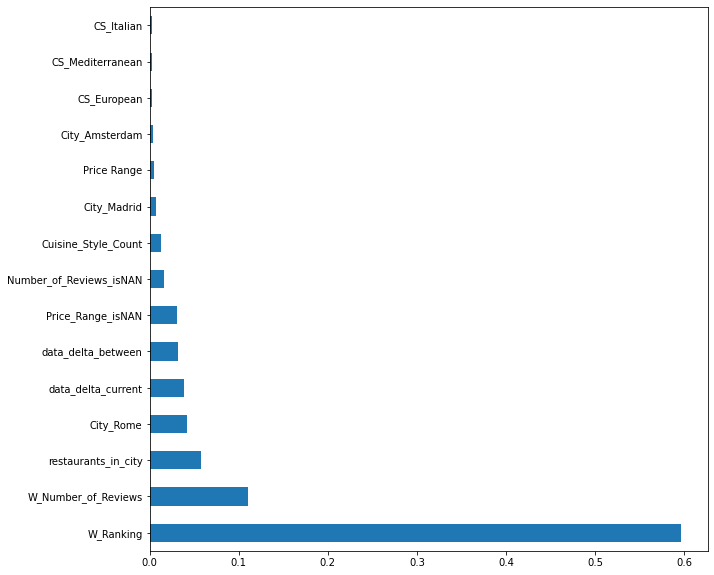

In [28]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [29]:
test_data.sample(10)

,Price Range,Rating,Number_of_Reviews_isNAN,data_delta_current,data_delta_between,Cuisine_Style_isNAN,Cuisine_Style_Count,CS_European,CS_Gluten Free Options,CS_Italian,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price_Range_isNAN,restaurants_in_city,W_Ranking,W_Number_of_Reviews
5216,50,0.0,1,1321.476782,144.694755,1,3,0,0,0,...,0,0,0,0,0,0,1,3395,2.032106,0.039966
8535,50,0.0,0,1897.000000,166.832472,1,3,1,0,0,...,0,0,0,0,0,0,1,1314,2.233638,0.070508
8354,50,0.0,0,1220.000000,143.359817,0,1,0,0,0,...,0,0,0,0,0,0,1,1816,1.059471,0.001101
5178,50,0.0,0,1514.000000,476.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,1145,1.979913,0.017467
2768,50,0.0,0,1857.000000,20.000000,0,3,0,0,1,...,0,0,0,0,0,0,0,1186,0.985666,0.012648
1386,50,0.0,0,1298.000000,51.000000,0,5,1,1,0,...,0,1,0,0,0,0,0,1033,0.229429,0.153921
8712,50,0.0,0,1157.000000,207.000000,0,3,1,0,0,...,0,0,0,0,0,0,0,3813,2.109625,0.111461
9,50,0.0,0,1102.000000,34.000000,0,1,0,0,1,...,0,1,0,0,0,0,1,1033,0.585673,0.012585
2236,50,0.0,1,1369.234711,170.872397,1,3,0,0,0,...,0,0,0,0,0,0,1,3813,2.293994,0.026203
5670,10,0.0,0,1164.000000,9.000000,0,7,0,1,0,...,0,0,0,0,0,0,0,6108,0.131467,0.060413


In [30]:
test_data = test_data.drop(['Rating'], axis=1)

In [31]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [32]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [33]:
predict_submission

array([3.055, 4.34 , 4.485, ..., 3.115, 4.545, 4.39 ])

In [34]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.055
1,id_1,4.340
2,id_2,4.485
3,id_3,4.410
4,id_4,4.405
5,id_5,4.355
6,id_6,3.060
7,id_7,2.505
8,id_8,4.230
9,id_9,4.630


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
